In [13]:
!pip install -U portalocker>=2.0.0 optuna-integration matplotlib plotly scikit-learn nbformat>=4.2.0 pandas

## Task - 1

### PyTorch FC ANN MNIST Implementation.

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader
from optuna.integration import PyTorchLightningPruningCallback
from torch.optim.lr_scheduler import ReduceLROnPlateau
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau as ReduceLROnPlateauKeras
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [49]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 64
train_val_split = 0.8

# This dataset is already "sorted" as part of the import method, but no "validation" set has been selected in this case
# Loading the FashionMNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Calculate sizes
train_size = int(train_val_split * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [5]:
# Mapping the labels for the MNIST dataset -- later we'll see that this using the "keras to_categorical" method as discussed in class
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

In [6]:
# Here we define the model parameters -- the general strucutre as provided here will produce a fully connected network [28x28] --> 32 --> 16 --> 10
class MLP(nn.Module): # MLP stands for "Multi-Layer Perceptron"
    def __init__(self, layer_sizes, activation_functions): # this initializes the structure of the network
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.drops = nn.ModuleList()
        input_size = 28 * 28 ## 28*28 input features and 32 outputs
        for size in layer_sizes:
            self.layers.append(nn.Linear(input_size, size))
            self.norms.append(nn.BatchNorm1d(size))
            self.drops.append(nn.Dropout(0.2))
            input_size = size
        
        self.activation_functions = activation_functions
        self.output_layer = nn.Linear(input_size, 10) ## 10 output features because MNIST has 10 target classes

    def forward(self, x): # this modifies the elements of the intial structure defined above
        x = x.view(-1, 28 * 28)  # Flatten the input
        for layer, activation, norm, drop in zip(self.layers, self.activation_functions, self.norms, self.drops):
            x = activation(layer(x))
            x = norm(x)
            x = drop(x)
        x = self.output_layer(x)
        return x

In [7]:
def objective(trial):
    num_layers = trial.suggest_int('num_layers', 1, 3)
    layer_sizes = []
    activation_functions = []
    activations = {
        'relu': nn.ReLU(),
        'sigmoid': nn.Sigmoid(),
        'tanh': nn.Tanh(),
        'gelu': nn.GELU(),
        'leaky_relu': nn.LeakyReLU(),
        'silu': nn.SiLU(),
    }

    optimizers = {
        'SGD': optim.SGD,
        'Adam': optim.Adam,
        'RMSprop': optim.RMSprop,
    }

    for i in range(num_layers):
        layer_size = trial.suggest_categorical(f'layer_size_{i}', [16, 32, 64, 128, 256, 512])
        activation_name = trial.suggest_categorical(f'activation_{i}', ['relu', 'sigmoid', 'tanh', 'gelu', 'leaky_relu', 'silu'])
        layer_sizes.append(layer_size)
        activation_functions.append(activations[activation_name])

    # Suggest optimizer
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'RMSprop'])

    # Suggest learning rate
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

    # Suggest batch size
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Initialize the model
    model = MLP(layer_sizes, activation_functions)
    criterion = nn.CrossEntropyLoss()

    # Create optimizer
    optimizer_class = optimizers[optimizer_name]
    optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=1e-4)

    # Data loaders with suggested batch size
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation at the end of each epoch
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total

        # Report intermediate objective value to the trial
        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [8]:
def run_studies(study_name, db_name, n_trials, resume=False):
    pruner = optuna.pruners.MedianPruner()
    db_url = 'sqlite:///' + db_name
    study = None
    if os.path.exists(db_name) and not resume:
        study = optuna.load_study(study_name=study_name, storage=db_url, pruner=pruner)
    else:
        study = optuna.create_study(
            study_name=study_name,
            storage=db_url,
            load_if_exists=True,
            direction='maximize',
            pruner=pruner
        )
        study.optimize(objective, n_trials=n_trials)


    print('Best hyperparameters:', study.best_params)
    return study

In [35]:
mnist_study = run_studies('mnist_study', 'mnist_study.db', 100)

Best hyperparameters: {'num_layers': 1, 'layer_size_0': 128, 'activation_0': 'silu', 'optimizer': 'SGD', 'lr': 0.09472452556756873, 'batch_size': 64}


In [10]:
mnist_study_df = mnist_study.trials_dataframe()
mnist_study_df.head()

,number,value,datetime_start,datetime_complete,duration,params_activation_0,params_activation_1,params_activation_2,params_batch_size,params_layer_size_0,params_layer_size_1,params_layer_size_2,params_lr,params_num_layers,params_optimizer,state
0,0,0.928083,2024-10-26 09:06:50.444934,2024-10-26 09:10:27.817575,0 days 00:03:37.372641,leaky_relu,gelu,relu,128,32,32.0,256.0,0.001778,3,Adam,COMPLETE
1,1,0.856500,2024-10-26 09:10:27.849171,2024-10-26 09:14:03.870207,0 days 00:03:36.021036,leaky_relu,silu,tanh,128,16,64.0,128.0,0.000022,3,RMSprop,COMPLETE
2,2,0.900167,2024-10-26 09:14:03.884601,2024-10-26 09:17:42.078555,0 days 00:03:38.193954,leaky_relu,gelu,sigmoid,64,32,512.0,64.0,0.001389,3,SGD,COMPLETE
3,3,0.090583,2024-10-26 09:17:42.091372,2024-10-26 09:21:23.680864,0 days 00:03:41.589492,gelu,relu,tanh,64,512,512.0,16.0,0.008522,3,RMSprop,COMPLETE
4,4,0.905333,2024-10-26 09:21:23.697584,2024-10-26 09:25:00.670021,0 days 00:03:36.972437,relu,gelu,silu,128,32,128.0,64.0,0.003468,3,SGD,COMPLETE


In [11]:
mnist_study_df.describe()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_layer_size_0,params_layer_size_1,params_layer_size_2,params_lr,params_num_layers
count,47.000000,46.000000,47,47,47,47.000000,47.000000,17.000000,7.000000,47.000000,47.000000
mean,23.000000,0.873745,2024-10-26 10:16:17.010326528,2024-10-26 10:18:54.096816384,0 days 00:02:37.086489468,65.361702,140.255319,193.882353,153.142857,0.028809,1.510638
min,0.000000,0.090583,2024-10-26 09:06:50.444934,2024-10-26 09:10:27.817575,0 days 00:00:21.660344,32.000000,16.000000,16.000000,16.000000,0.000012,1.000000
25%,11.500000,0.865500,2024-10-26 09:42:39.467578624,2024-10-26 09:46:20.223440640,0 days 00:00:22.106403500,48.000000,64.000000,64.000000,48.000000,0.000458,1.000000
50%,23.000000,0.951333,2024-10-26 10:21:22.620493056,2024-10-26 10:24:59.588225024,0 days 00:03:36.967732,64.000000,128.000000,256.000000,64.000000,0.011640,1.000000
75%,34.500000,0.963458,2024-10-26 10:53:11.692732672,2024-10-26 10:55:10.380280064,0 days 00:03:37.880288500,64.000000,128.000000,256.000000,192.000000,0.050797,2.000000
max,46.000000,0.969250,2024-10-26 11:08:45.723182,2024-10-26 11:09:54.309600,0 days 00:03:43.260054,128.000000,512.000000,512.000000,512.000000,0.099575,3.000000
std,13.711309,0.186722,NaN,NaN,0 days 00:01:30.721633003,29.808392,130.421135,155.628517,177.654560,0.034097,0.748109


In [13]:
mnist_study_df['state'].value_counts()

state
COMPLETE    32
PRUNED      14
FAIL         1
Name: count, dtype: int64

In [12]:
completed = mnist_study_df[~mnist_study_df['state'].isin(['RUNNING', 'FAIL'])]
completed_cleaned = completed.drop(columns=['state', 'datetime_start', 'datetime_complete', 'number', 'duration'])
completed_cleaned.sort_values('value', ascending=False, inplace=True, ignore_index=True)
completed_cleaned.head()

,value,params_activation_0,params_activation_1,params_activation_2,params_batch_size,params_layer_size_0,params_layer_size_1,params_layer_size_2,params_lr,params_num_layers,params_optimizer
0,0.969250,silu,NaN,NaN,64,128,NaN,NaN,0.094725,1,SGD
1,0.968000,silu,NaN,NaN,64,128,NaN,NaN,0.056040,1,SGD
2,0.967000,silu,NaN,NaN,64,128,NaN,NaN,0.097456,1,SGD
3,0.966167,silu,NaN,NaN,64,128,NaN,NaN,0.076446,1,SGD
4,0.965917,silu,NaN,NaN,64,128,NaN,NaN,0.095923,1,SGD


In [32]:
completed_cleaned.describe()

,value,params_batch_size,params_layer_size_0,params_layer_size_1,params_layer_size_2,params_lr,params_num_layers
count,46.000000,46.000000,46.00000,17.000000,7.000000,46.000000,46.000000
mean,0.873745,65.391304,137.73913,193.882353,153.142857,0.028979,1.521739
std,0.186722,30.137078,130.70381,155.628517,177.654560,0.034453,0.752452
min,0.090583,32.000000,16.00000,16.000000,16.000000,0.000012,1.000000
25%,0.865500,40.000000,64.00000,64.000000,48.000000,0.000456,1.000000
50%,0.951333,64.000000,128.00000,256.000000,64.000000,0.010086,1.000000
75%,0.963458,64.000000,128.00000,256.000000,192.000000,0.051740,2.000000
max,0.969250,128.000000,512.00000,512.000000,512.000000,0.099575,3.000000


In [33]:
completed_cleaned['params_activation_0'].value_counts()

params_activation_0
silu          21
sigmoid        7
relu           5
leaky_relu     5
tanh           4
gelu           4
Name: count, dtype: int64

In [14]:
optuna.visualization.plot_param_importances(mnist_study)

In [36]:
# view distribution of hyperparameters w.r.t. accuracy
optuna.visualization.plot_optimization_history(mnist_study)

In [37]:
optuna.visualization.plot_slice(mnist_study)

In [38]:
mnist_study_df.to_csv('mnist_trial_data.csv', index=False)

In [15]:
def train_config(model, train_data, val_data, optimizer, batch_size, num_epochs=3, use_tqdm=True):
    # Data loaders with suggested batch size
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    train_losses = []
    val_losses = []
    criterion = nn.CrossEntropyLoss()

    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=2,
        verbose=True,
        min_lr=1e-6
    )

    # Training the neural network
    if use_tqdm:
        epochs = tqdm(range(num_epochs))
    else:
        epochs = range(num_epochs)

    for epoch in epochs:
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:  # print every 100 mini-batches
                train_losses.append(running_loss / 100)
                running_loss = 0.0
                if not use_tqdm:
                    print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {train_losses[-1]}')

        running_loss = 0.0  # Reset running loss
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation
            for i, data in enumerate(val_loader, 0):
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

        scheduler.step(running_loss)
        # Log learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Validation Loss: {running_loss / len(val_loader)}, Learning Rate: {current_lr:.6f}')
        val_losses.append(running_loss / len(val_loader))
        model.train()  # Set model back to training mode

    return train_losses, val_losses

In [55]:
# 0.002, 0.001
learning_rate = 0.09
weight_decay = 1e-04
batch_size = 64
# Loss function and optimizer
all_losses = []
all_val_losses = []
# activations = [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.GELU(), nn.LeakyReLU(), nn.SiLU()]
activations = [nn.Tanh(), nn.SiLU()]
for activation in activations:
    model = MLP([128], [activation])
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_losses, val_losses = train_config(model, train_subset, val_subset, optimizer, batch_size, num_epochs=25)
    all_losses.append(train_losses)
    all_val_losses.append(val_losses)

c:\Users\rgbmr\anaconda3\envs\project2\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

  4%|▍         | 1/25 [00:08<03:24,  8.51s/it]

Validation Loss: 0.1770399761822154, Learning Rate: 0.090000


  8%|▊         | 2/25 [00:16<03:14,  8.45s/it]

Validation Loss: 0.13982420619775324, Learning Rate: 0.090000


 12%|█▏        | 3/25 [00:25<03:05,  8.44s/it]

Validation Loss: 0.12013261602260172, Learning Rate: 0.090000


 16%|█▌        | 4/25 [00:33<02:57,  8.46s/it]

Validation Loss: 0.10070436207349709, Learning Rate: 0.090000


 20%|██        | 5/25 [00:42<02:49,  8.48s/it]

Validation Loss: 0.09024728757844484, Learning Rate: 0.090000


 24%|██▍       | 6/25 [00:50<02:41,  8.50s/it]

Validation Loss: 0.08478470375028221, Learning Rate: 0.090000


 28%|██▊       | 7/25 [00:59<02:32,  8.50s/it]

Validation Loss: 0.08769677049093978, Learning Rate: 0.090000


 32%|███▏      | 8/25 [01:07<02:24,  8.52s/it]

Validation Loss: 0.09071615635060724, Learning Rate: 0.090000


 36%|███▌      | 9/25 [01:16<02:16,  8.52s/it]

Validation Loss: 0.08074183740524297, Learning Rate: 0.090000


 40%|████      | 10/25 [01:24<02:07,  8.52s/it]

Validation Loss: 0.07697385708563664, Learning Rate: 0.090000


 44%|████▍     | 11/25 [01:33<01:59,  8.53s/it]

Validation Loss: 0.0792693973647708, Learning Rate: 0.090000


 48%|████▊     | 12/25 [01:42<01:50,  8.53s/it]

Validation Loss: 0.09712421424944509, Learning Rate: 0.090000


 52%|█████▏    | 13/25 [01:50<01:42,  8.51s/it]

Validation Loss: 0.0879975347754922, Learning Rate: 0.009000


 56%|█████▌    | 14/25 [01:59<01:33,  8.51s/it]

Validation Loss: 0.06739698680850895, Learning Rate: 0.009000


 60%|██████    | 15/25 [02:07<01:25,  8.52s/it]

Validation Loss: 0.06536182460308253, Learning Rate: 0.009000


 64%|██████▍   | 16/25 [02:16<01:16,  8.50s/it]

Validation Loss: 0.06544862118886506, Learning Rate: 0.009000


 68%|██████▊   | 17/25 [02:24<01:07,  8.48s/it]

Validation Loss: 0.06464072189571217, Learning Rate: 0.009000


 72%|███████▏  | 18/25 [02:32<00:59,  8.47s/it]

Validation Loss: 0.06574526658539284, Learning Rate: 0.009000


 76%|███████▌  | 19/25 [02:41<00:50,  8.46s/it]

Validation Loss: 0.06423932670286182, Learning Rate: 0.009000


 80%|████████  | 20/25 [02:49<00:42,  8.45s/it]

Validation Loss: 0.06359052986458955, Learning Rate: 0.009000


 84%|████████▍ | 21/25 [02:58<00:33,  8.44s/it]

Validation Loss: 0.06394350111293805, Learning Rate: 0.009000


 88%|████████▊ | 22/25 [03:06<00:25,  8.40s/it]

Validation Loss: 0.06512711132428252, Learning Rate: 0.009000


 92%|█████████▏| 23/25 [03:14<00:16,  8.40s/it]

Validation Loss: 0.06374310862466177, Learning Rate: 0.000900


 96%|█████████▌| 24/25 [03:23<00:08,  8.44s/it]

Validation Loss: 0.06340689813294646, Learning Rate: 0.000900


100%|██████████| 25/25 [03:31<00:00,  8.48s/it]


Validation Loss: 0.06334373440799065, Learning Rate: 0.000900


  4%|▍         | 1/25 [00:08<03:23,  8.46s/it]

Validation Loss: 0.17628986299275717, Learning Rate: 0.090000


  8%|▊         | 2/25 [00:16<03:15,  8.49s/it]

Validation Loss: 0.12577171556334546, Learning Rate: 0.090000


 12%|█▏        | 3/25 [00:25<03:06,  8.46s/it]

Validation Loss: 0.10954767385339166, Learning Rate: 0.090000


 16%|█▌        | 4/25 [00:33<02:57,  8.45s/it]

Validation Loss: 0.10361069376937095, Learning Rate: 0.090000


 20%|██        | 5/25 [00:42<02:48,  8.45s/it]

Validation Loss: 0.096120821973408, Learning Rate: 0.090000


 24%|██▍       | 6/25 [00:50<02:40,  8.44s/it]

Validation Loss: 0.09052098994242384, Learning Rate: 0.090000


 28%|██▊       | 7/25 [00:59<02:31,  8.41s/it]

Validation Loss: 0.08829539258310452, Learning Rate: 0.090000


 32%|███▏      | 8/25 [01:07<02:23,  8.42s/it]

Validation Loss: 0.08631047412277536, Learning Rate: 0.090000


 36%|███▌      | 9/25 [01:15<02:14,  8.42s/it]

Validation Loss: 0.08997935482964634, Learning Rate: 0.090000


 40%|████      | 10/25 [01:24<02:06,  8.44s/it]

Validation Loss: 0.07555656252240643, Learning Rate: 0.090000


 44%|████▍     | 11/25 [01:32<01:58,  8.46s/it]

Validation Loss: 0.08616585389492994, Learning Rate: 0.090000


 48%|████▊     | 12/25 [01:41<01:49,  8.45s/it]

Validation Loss: 0.07556308647914928, Learning Rate: 0.090000


 52%|█████▏    | 13/25 [01:49<01:41,  8.44s/it]

Validation Loss: 0.07767967436650887, Learning Rate: 0.009000


 56%|█████▌    | 14/25 [01:58<01:32,  8.45s/it]

Validation Loss: 0.06370716613960116, Learning Rate: 0.009000


 60%|██████    | 15/25 [02:06<01:24,  8.45s/it]

Validation Loss: 0.06177401335221378, Learning Rate: 0.009000


 64%|██████▍   | 16/25 [02:15<01:15,  8.44s/it]

Validation Loss: 0.060124035803303916, Learning Rate: 0.009000


 68%|██████▊   | 17/25 [02:23<01:07,  8.41s/it]

Validation Loss: 0.05923435611506686, Learning Rate: 0.009000


 72%|███████▏  | 18/25 [02:31<00:58,  8.42s/it]

Validation Loss: 0.05933195295708967, Learning Rate: 0.009000


 76%|███████▌  | 19/25 [02:40<00:50,  8.41s/it]

Validation Loss: 0.05900696596314021, Learning Rate: 0.009000


 80%|████████  | 20/25 [02:48<00:42,  8.40s/it]

Validation Loss: 0.058059543732831134, Learning Rate: 0.009000


 84%|████████▍ | 21/25 [02:57<00:33,  8.40s/it]

Validation Loss: 0.05868423537925837, Learning Rate: 0.009000


 88%|████████▊ | 22/25 [03:05<00:25,  8.41s/it]

Validation Loss: 0.05808639513734887, Learning Rate: 0.009000


 92%|█████████▏| 23/25 [03:14<00:16,  8.46s/it]

Validation Loss: 0.05776652290753307, Learning Rate: 0.009000


 96%|█████████▌| 24/25 [03:22<00:08,  8.48s/it]

Validation Loss: 0.05748960085119061, Learning Rate: 0.009000


100%|██████████| 25/25 [03:31<00:00,  8.44s/it]

Validation Loss: 0.057938524676694914, Learning Rate: 0.009000


In [57]:
final_model = MLP([128], [nn.SiLU()])
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train_losses, val_losses = train_config(model, train_subset, val_subset, optimizer, batch_size, num_epochs=15)

c:\Users\rgbmr\anaconda3\envs\project2\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

  7%|▋         | 1/15 [00:08<01:58,  8.43s/it]

Validation Loss: 0.07300064079104328, Learning Rate: 0.090000


 13%|█▎        | 2/15 [00:16<01:49,  8.40s/it]

Validation Loss: 0.0736970650812393, Learning Rate: 0.090000


 20%|██        | 3/15 [00:25<01:40,  8.40s/it]

Validation Loss: 0.06873505070627212, Learning Rate: 0.090000


 27%|██▋       | 4/15 [00:33<01:32,  8.39s/it]

Validation Loss: 0.07751163218462681, Learning Rate: 0.090000


 33%|███▎      | 5/15 [00:42<01:23,  8.40s/it]

Validation Loss: 0.07805278692010573, Learning Rate: 0.090000


 40%|████      | 6/15 [00:50<01:15,  8.39s/it]

Validation Loss: 0.07246532610077609, Learning Rate: 0.009000


 47%|████▋     | 7/15 [00:58<01:07,  8.40s/it]

Validation Loss: 0.0594038948097187, Learning Rate: 0.009000


 53%|█████▎    | 8/15 [01:07<00:58,  8.39s/it]

Validation Loss: 0.05881042816141184, Learning Rate: 0.009000


 60%|██████    | 9/15 [01:15<00:50,  8.38s/it]

Validation Loss: 0.057443121654982186, Learning Rate: 0.009000


 67%|██████▋   | 10/15 [01:23<00:41,  8.40s/it]

Validation Loss: 0.05874941914783236, Learning Rate: 0.009000


 73%|███████▎  | 11/15 [01:32<00:33,  8.40s/it]

Validation Loss: 0.058756774259196155, Learning Rate: 0.009000


 80%|████████  | 12/15 [01:40<00:25,  8.41s/it]

Validation Loss: 0.05781766348902354, Learning Rate: 0.000900


 87%|████████▋ | 13/15 [01:49<00:16,  8.40s/it]

Validation Loss: 0.056657704710465, Learning Rate: 0.000900


 93%|█████████▎| 14/15 [01:57<00:08,  8.39s/it]

Validation Loss: 0.05758607855557087, Learning Rate: 0.000900


100%|██████████| 15/15 [02:05<00:00,  8.40s/it]

Validation Loss: 0.057343583762090894, Learning Rate: 0.000900


C:\Users\rgbmr\AppData\Local\Temp\ipykernel_12140\2481862998.py:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



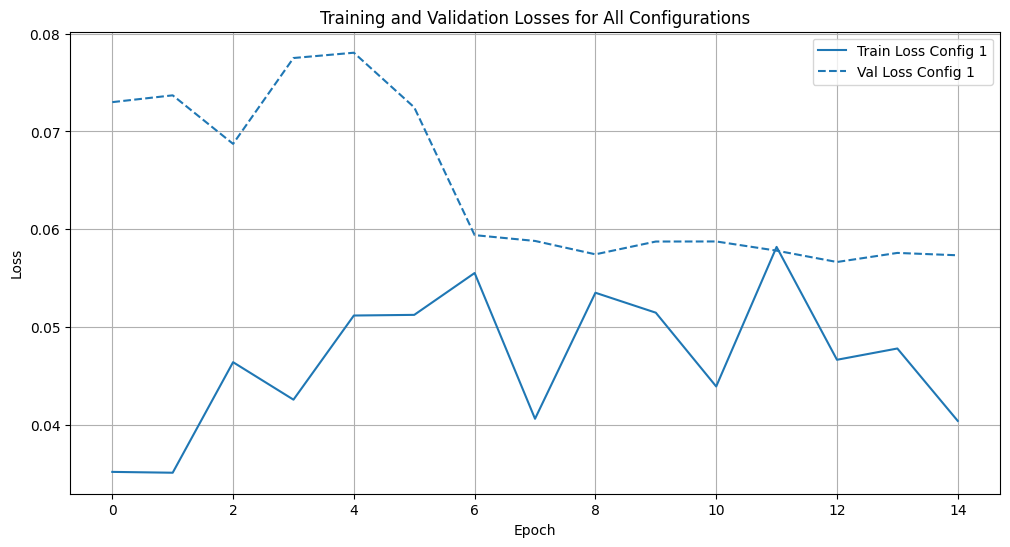

In [58]:
def plot_losses(all_train_losses, all_val_losses):
    plt.figure(figsize=(12, 6))  # Set a suitable figure size
    num_configs = len(all_train_losses)
    colors = plt.cm.get_cmap('tab10', num_configs)  # Get a color map with enough colors

    for idx, (train_losses, val_losses) in enumerate(zip(all_train_losses, all_val_losses)):
        # Use different colors for each configuration
        color = colors(idx)
        # Plot training losses with solid lines
        plt.plot(train_losses[:len(val_losses)], label=f'Train Loss Config {idx+1}', color=color, linestyle='-')
        # Plot validation losses with dashed lines
        plt.plot(val_losses, label=f'Val Loss Config {idx+1}', color=color, linestyle='--')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses for All Configurations')
    plt.legend()
    plt.grid(True)
    plt.show()

# plot_losses(all_losses, all_val_losses)
plot_losses([train_losses], [val_losses])

In [59]:
# Evaluating the model
model.eval()
correct = 0
total = 0
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { correct / total}')

Accuracy on test set: 0.9816


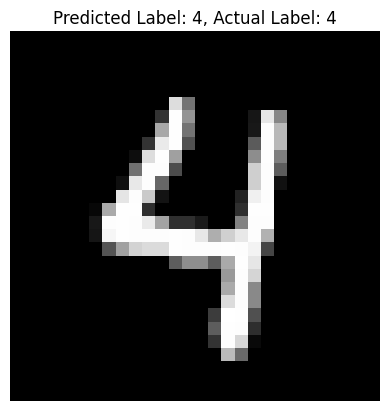

In [60]:
image_index = 27
test_image, test_label = test_dataset[image_index]

with torch.no_grad():
    model.eval()
    output = model(test_image.unsqueeze(0))
    _, predicted_label = torch.max(output, 1)

test_image_numpy = test_image.squeeze().numpy()

plt.imshow(test_image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predicted_label.item()}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

Notes for Part 1

1. Activation function:

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))  # Change activation function here
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

2. loss function and optimizer

model = Net()
criterion = torch.nn.CrossEntropyLoss()  # Change loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

3. ~adding a dropout layer

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.dropout = torch.nn.Dropout(0.2)  # Add a Dropout layer here
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply Dropout
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

4. model configurations / epochs

epochs = 10  # Change number of epochs
for epoch in range(epochs):
    # Training loop
    for i, data in enumerate(train_loader, 0):
        # Training steps

## Task - 2

### PyTorch FC ANN FMNIST Implementation


In [66]:
# Transformations --> this is a "pre-processing step" that's typical for image processing methods
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

train_val_split = 0.8

# This dataset is already "sorted" as part of the import method, but no "validation" set has been selected in this case
# Loading the FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Calculate sizes
train_size = int(train_val_split * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [62]:
# Mapping the labels for the FashionMNIST dataset -- later we'll see that this using the "keras to_categorical" method as discussed in class
labels_map = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
}

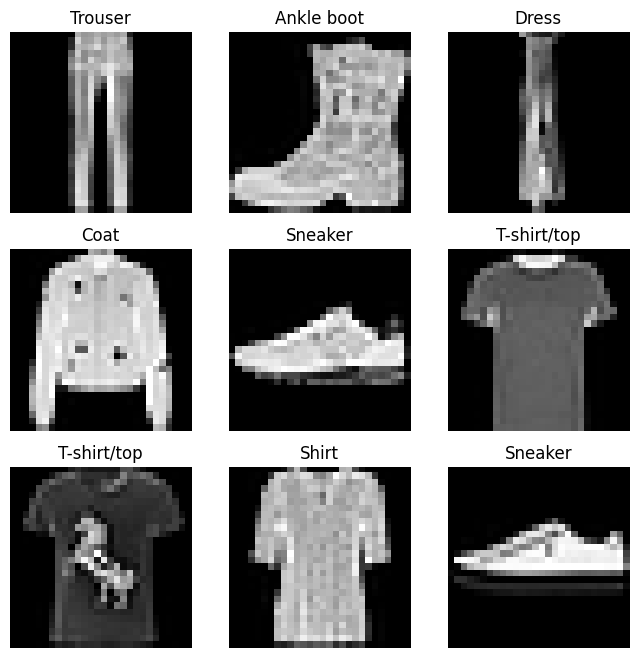

In [63]:
#This cell is designed to display a few images from the dataset
#It isn't necessary to run this, but it can help give a better idea of the challanges your model will face
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Displaying figures from the dataset randomly
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [64]:
fmnist_study = run_studies('fmnist_study', 'fmnist_study.db', 100)

Best hyperparameters: {'num_layers': 1, 'layer_size_0': 128, 'activation_0': 'gelu', 'optimizer': 'RMSprop', 'batch_size': 32}


In [20]:
fmnist_trial_df = fmnist_study.trials_dataframe()
fmnist_trial_df.head()

,number,value,datetime_start,datetime_complete,duration,params_activation_0,params_activation_1,params_activation_2,params_batch_size,params_layer_size_0,params_layer_size_1,params_layer_size_2,params_num_layers,params_optimizer,state
0,0,0.854083,2024-10-26 11:23:19.844195,2024-10-26 11:29:54.026546,0 days 00:06:34.182351,relu,tanh,NaN,64,512,256.0,NaN,2,SGD,COMPLETE
1,1,0.883667,2024-10-26 11:23:19.944459,2024-10-26 11:29:47.438901,0 days 00:06:27.494442,leaky_relu,gelu,NaN,128,64,64.0,NaN,2,Adam,COMPLETE
2,2,0.883417,2024-10-26 11:23:20.061123,2024-10-26 11:29:51.774194,0 days 00:06:31.713071,silu,relu,silu,128,128,64.0,128.0,3,RMSprop,COMPLETE
3,3,0.741167,2024-10-26 11:23:20.061123,2024-10-26 11:29:57.258470,0 days 00:06:37.197347,sigmoid,relu,sigmoid,64,64,256.0,32.0,3,SGD,COMPLETE
4,4,0.888250,2024-10-26 11:29:47.454532,2024-10-26 11:36:15.726716,0 days 00:06:28.272184,gelu,NaN,NaN,64,128,NaN,NaN,1,RMSprop,COMPLETE


In [21]:
completed_trials = fmnist_trial_df[fmnist_trial_df['state'] == 'COMPLETE']
completed_trials.describe()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_layer_size_0,params_layer_size_1,params_layer_size_2,params_num_layers
count,13.000000,13.000000,13,13,13,13.000000,13.000000,5.000000,2.000000,13.000000
mean,14.615385,0.872942,2024-10-26 12:42:08.280228352,2024-10-26 12:48:45.419806720,0 days 00:06:37.139577846,64.000000,157.538462,179.200000,80.000000,1.538462
min,0.000000,0.741167,2024-10-26 11:23:19.844195,2024-10-26 11:29:47.438901,0 days 00:05:36.332540,32.000000,64.000000,64.000000,32.000000,1.000000
25%,3.000000,0.882833,2024-10-26 11:23:20.061123072,2024-10-26 11:29:57.258469888,0 days 00:05:57.208855,32.000000,128.000000,64.000000,56.000000,1.000000
50%,13.000000,0.885083,2024-10-26 11:37:47.465961984,2024-10-26 11:43:34.801115904,0 days 00:06:28.272184,64.000000,128.000000,256.000000,80.000000,1.000000
75%,19.000000,0.888250,2024-10-26 12:00:45.200034048,2024-10-26 12:08:56.467325952,0 days 00:06:37.197347,64.000000,128.000000,256.000000,104.000000,2.000000
max,43.000000,0.893250,2024-10-26 18:21:18.520079,2024-10-26 18:26:54.852619,0 days 00:08:11.267292,128.000000,512.000000,256.000000,128.000000,3.000000
std,13.555678,0.040747,NaN,NaN,0 days 00:00:55.189206025,39.191836,115.718491,105.162731,67.882251,0.776250


In [26]:
completed_trials['params_activation_2'].value_counts()

params_activation_2
silu    6
relu    6
tanh    2
gelu    1
Name: count, dtype: int64

In [8]:
# group by params_activation_0 and agg by value
fmnist_trial_df.groupby('params_activation_0').agg({'value': ['mean', 'std']})

value          
                         mean       std
params_activation_0                    
gelu                 0.782537  0.050186
leaky_relu           0.765214  0.056212
relu                 0.703917  0.161625
sigmoid              0.758250  0.052826
silu                 0.787181  0.034987
tanh                 0.731345  0.109043

In [22]:
single_layer_trials = fmnist_trial_df[fmnist_trial_df['params_num_layers'] == 1]
single_layer_trials.head()

,number,value,datetime_start,datetime_complete,duration,params_activation_0,params_activation_1,params_activation_2,params_batch_size,params_layer_size_0,params_layer_size_1,params_layer_size_2,params_num_layers,params_optimizer,state
4,4,0.888250,2024-10-26 11:29:47.454532,2024-10-26 11:36:15.726716,0 days 00:06:28.272184,gelu,NaN,NaN,64,128,NaN,NaN,1,RMSprop,COMPLETE
8,8,0.866500,2024-10-26 11:36:15.742340,2024-10-26 11:38:12.877196,0 days 00:01:57.134856,silu,NaN,NaN,64,64,NaN,NaN,1,RMSprop,PRUNED
13,13,0.891917,2024-10-26 11:37:47.465962,2024-10-26 11:43:34.801116,0 days 00:05:47.335154,gelu,NaN,NaN,32,128,NaN,NaN,1,RMSprop,COMPLETE
14,14,0.834583,2024-10-26 11:38:12.895779,2024-10-26 11:38:52.619550,0 days 00:00:39.723771,gelu,NaN,NaN,32,16,NaN,NaN,1,Adam,PRUNED
15,15,0.883000,2024-10-26 11:42:22.978340,2024-10-26 11:47:01.813513,0 days 00:04:38.835173,leaky_relu,NaN,NaN,128,256,NaN,NaN,1,RMSprop,PRUNED


In [23]:
single_layer_trials.shape

(31, 15)

In [24]:
# view distribution of hyperparameters w.r.t. accuracy
optuna.visualization.plot_optimization_history(fmnist_study)

In [65]:
optuna.visualization.plot_param_importances(fmnist_study)

Top two hyperparameters in terms of importance. Want to build out a more clear distribution. Seems to maximize around 2 layers deep, with 200 or less nodes in the first layer.

In [43]:
# plot value vs num layers
optuna.visualization.plot_slice(fmnist_study)

In [70]:
fmnist_trial_df.to_csv('fmnist_trial_data.csv', index=False)

In [44]:
def new_objective(trial):
    # Suggest hyperparameters
    num_layers = trial.suggest_int('num_layers', 2, 5)
    layer_sizes = []
    activation_functions = []
    activations = {
        'relu': nn.ReLU(),
        'sigmoid': nn.Sigmoid(),
        'tanh': nn.Tanh(),
        'gelu': nn.GELU(),
        'leaky_relu': nn.LeakyReLU(),
        'silu': nn.SiLU(),
    }

    for i in range(num_layers):
        layer_size = trial.suggest_categorical(f'layer_size_{i}', [32, 64, 128, 256, 512, 784])
        activation_name = trial.suggest_categorical(f'activation_{i}', ['relu', 'sigmoid', 'tanh', 'gelu', 'leaky_relu', 'silu'])
        layer_sizes.append(layer_size)
        activation_functions.append(activations[activation_name])

    # Suggest learning rate
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

    # Initialize the model
    model = MLP(layer_sizes, activation_functions)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-4)

    # Data loaders with suggested batch size
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation at the end of each epoch
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total

        # Report intermediate objective value to the trial
        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [50]:
best_rate = 9.111332423026142e-05
learning_rates = [0.001, 0.0001, 0.00001]
print(learning_rates)

[0.001, 0.0001, 1e-05]


In [31]:
learning_rates = np.logspace(-5, -1, num=10)
learning_rates

array([1.00000000e-05, 2.78255940e-05, 7.74263683e-05, 2.15443469e-04,
       5.99484250e-04, 1.66810054e-03, 4.64158883e-03, 1.29154967e-02,
       3.59381366e-02, 1.00000000e-01])

In [31]:
all_losses = []
all_val_losses = []
# first_layer_sizes = [32, 64, 128, 256, 512, 1024]
# learning_rate = 0.00017126243071531458
# activations = [nn.ReLU(), nn.SiLU(), nn.ELU(), nn.LeakyReLU(), nn.GELU(), nn.Sigmoid(), nn.Tanh()]
# activations = [nn.ReLU(), nn.SiLU(), nn.ELU(), nn.LeakyReLU(), nn.GELU()]
best_decay_so_far = 6.128782742220545e-06
#weight_decays = np.logspace(-7, -3, num=5)
activations = [nn.SiLU(), nn.ELU()]

for activation in activations:
    # Loss function and optimizer
    model = MLP([128], [activation])
    optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-4)

    train_losses, val_losses = train_config(model, train_subset, val_subset, optimizer, batch_size=32, num_epochs=30)
    
    all_losses.append(train_losses)
    all_val_losses.append(val_losses)

    print('Finished Training for activation:', str(activation))

  3%|▎         | 1/30 [00:09<04:25,  9.16s/it]

Validation Loss: 0.4259939146240552, Learning Rate: 0.001000


  7%|▋         | 2/30 [00:18<04:18,  9.23s/it]

Validation Loss: 0.40683157261212666, Learning Rate: 0.001000


 10%|█         | 3/30 [00:27<04:08,  9.22s/it]

Validation Loss: 0.40173472424348194, Learning Rate: 0.001000


 13%|█▎        | 4/30 [00:36<03:59,  9.21s/it]

Validation Loss: 0.39830897812048593, Learning Rate: 0.001000


 17%|█▋        | 5/30 [00:46<03:50,  9.21s/it]

Validation Loss: 0.39152412259578706, Learning Rate: 0.001000


 20%|██        | 6/30 [00:55<03:40,  9.20s/it]

Validation Loss: 0.37468583617607754, Learning Rate: 0.001000


 23%|██▎       | 7/30 [01:04<03:31,  9.20s/it]

Validation Loss: 0.37167644329865773, Learning Rate: 0.001000


 27%|██▋       | 8/30 [01:13<03:22,  9.21s/it]

Validation Loss: 0.3516183753311634, Learning Rate: 0.001000


 30%|███       | 9/30 [01:22<03:13,  9.20s/it]

Validation Loss: 0.4065780966281891, Learning Rate: 0.001000


 33%|███▎      | 10/30 [01:32<03:04,  9.20s/it]

Validation Loss: 0.3556454288760821, Learning Rate: 0.001000


 37%|███▋      | 11/30 [01:41<02:54,  9.19s/it]

Validation Loss: 0.34461654512087503, Learning Rate: 0.001000


 40%|████      | 12/30 [01:50<02:45,  9.22s/it]

Validation Loss: 0.35576211708784106, Learning Rate: 0.001000


 43%|████▎     | 13/30 [01:59<02:36,  9.22s/it]

Validation Loss: 0.36687831530968346, Learning Rate: 0.001000


 47%|████▋     | 14/30 [02:09<02:28,  9.25s/it]

Validation Loss: 0.37397371313969296, Learning Rate: 0.000100


 50%|█████     | 15/30 [02:18<02:18,  9.25s/it]

Validation Loss: 0.31776138680179916, Learning Rate: 0.000100


 53%|█████▎    | 16/30 [02:27<02:09,  9.24s/it]

Validation Loss: 0.31885184050599735, Learning Rate: 0.000100


 57%|█████▋    | 17/30 [02:36<02:00,  9.24s/it]

Validation Loss: 0.3172154976129532, Learning Rate: 0.000100


 60%|██████    | 18/30 [02:45<01:50,  9.21s/it]

Validation Loss: 0.315595857411623, Learning Rate: 0.000100


 63%|██████▎   | 19/30 [02:55<01:41,  9.22s/it]

Validation Loss: 0.31407538914680483, Learning Rate: 0.000100


 67%|██████▋   | 20/30 [03:04<01:32,  9.22s/it]

Validation Loss: 0.31320150499542554, Learning Rate: 0.000100


 70%|███████   | 21/30 [03:13<01:22,  9.20s/it]

Validation Loss: 0.31416009961565333, Learning Rate: 0.000100


 73%|███████▎  | 22/30 [03:22<01:13,  9.20s/it]

Validation Loss: 0.31238370171189306, Learning Rate: 0.000100


 77%|███████▋  | 23/30 [03:31<01:04,  9.19s/it]

Validation Loss: 0.3213407086332639, Learning Rate: 0.000100


 80%|████████  | 24/30 [03:41<00:55,  9.23s/it]

Validation Loss: 0.31278650714953743, Learning Rate: 0.000100


 83%|████████▎ | 25/30 [03:50<00:46,  9.24s/it]

Validation Loss: 0.3146518785556157, Learning Rate: 0.000010


 87%|████████▋ | 26/30 [03:59<00:36,  9.22s/it]

Validation Loss: 0.31145145242412886, Learning Rate: 0.000010


 90%|█████████ | 27/30 [04:08<00:27,  9.21s/it]

Validation Loss: 0.3141721618870894, Learning Rate: 0.000010


 93%|█████████▎| 28/30 [04:18<00:18,  9.20s/it]

Validation Loss: 0.310639564593633, Learning Rate: 0.000010


 97%|█████████▋| 29/30 [04:27<00:09,  9.22s/it]

Validation Loss: 0.3106420117119948, Learning Rate: 0.000010


100%|██████████| 30/30 [04:36<00:00,  9.22s/it]


Validation Loss: 0.31068597587943075, Learning Rate: 0.000010
Finished Training for activation: SiLU()


  3%|▎         | 1/30 [00:09<04:26,  9.18s/it]

Validation Loss: 0.42744984702269234, Learning Rate: 0.001000


  7%|▋         | 2/30 [00:18<04:18,  9.21s/it]

Validation Loss: 0.40742556631565097, Learning Rate: 0.001000


 10%|█         | 3/30 [00:27<04:08,  9.21s/it]

Validation Loss: 0.38454216613372166, Learning Rate: 0.001000


 13%|█▎        | 4/30 [00:36<03:59,  9.22s/it]

Validation Loss: 0.36366528081893923, Learning Rate: 0.001000


 17%|█▋        | 5/30 [00:46<03:50,  9.22s/it]

Validation Loss: 0.36076343871156374, Learning Rate: 0.001000


 20%|██        | 6/30 [00:55<03:41,  9.22s/it]

Validation Loss: 0.35080871398250263, Learning Rate: 0.001000


 23%|██▎       | 7/30 [01:04<03:32,  9.22s/it]

Validation Loss: 0.36328528154889744, Learning Rate: 0.001000


 27%|██▋       | 8/30 [01:13<03:22,  9.22s/it]

Validation Loss: 0.34697601361076036, Learning Rate: 0.001000


 30%|███       | 9/30 [01:23<03:13,  9.24s/it]

Validation Loss: 0.3565195718407631, Learning Rate: 0.001000


 33%|███▎      | 10/30 [01:32<03:05,  9.26s/it]

Validation Loss: 0.39348729558785756, Learning Rate: 0.001000


 37%|███▋      | 11/30 [01:41<02:55,  9.26s/it]

Validation Loss: 0.3443717680573463, Learning Rate: 0.001000


 40%|████      | 12/30 [01:50<02:46,  9.24s/it]

Validation Loss: 0.33850027883052825, Learning Rate: 0.001000


 43%|████▎     | 13/30 [02:00<02:37,  9.24s/it]

Validation Loss: 0.3325789061784744, Learning Rate: 0.001000


 47%|████▋     | 14/30 [02:09<02:27,  9.22s/it]

Validation Loss: 0.32483107143640516, Learning Rate: 0.001000


 50%|█████     | 15/30 [02:18<02:19,  9.29s/it]

Validation Loss: 0.33544746377070744, Learning Rate: 0.001000


 53%|█████▎    | 16/30 [02:28<02:10,  9.31s/it]

Validation Loss: 0.4164785457253456, Learning Rate: 0.001000


 57%|█████▋    | 17/30 [02:37<02:00,  9.27s/it]

Validation Loss: 0.34983612106243767, Learning Rate: 0.000100


 60%|██████    | 18/30 [02:46<01:51,  9.27s/it]

Validation Loss: 0.3064531061848005, Learning Rate: 0.000100


 63%|██████▎   | 19/30 [02:55<01:41,  9.27s/it]

Validation Loss: 0.3138648619403442, Learning Rate: 0.000100


 67%|██████▋   | 20/30 [03:04<01:32,  9.26s/it]

Validation Loss: 0.3025812628964583, Learning Rate: 0.000100


 70%|███████   | 21/30 [03:14<01:23,  9.25s/it]

Validation Loss: 0.29905269385377564, Learning Rate: 0.000100


 73%|███████▎  | 22/30 [03:23<01:13,  9.25s/it]

Validation Loss: 0.3124941452195247, Learning Rate: 0.000100


 77%|███████▋  | 23/30 [03:32<01:04,  9.23s/it]

Validation Loss: 0.305946830218037, Learning Rate: 0.000100


 80%|████████  | 24/30 [03:41<00:55,  9.20s/it]

Validation Loss: 0.3034221820185582, Learning Rate: 0.000010


 83%|████████▎ | 25/30 [03:51<00:46,  9.22s/it]

Validation Loss: 0.30050960819919903, Learning Rate: 0.000010


 87%|████████▋ | 26/30 [04:00<00:36,  9.21s/it]

Validation Loss: 0.30599545236428577, Learning Rate: 0.000010


 90%|█████████ | 27/30 [04:09<00:27,  9.21s/it]

Validation Loss: 0.3053743867278099, Learning Rate: 0.000001


 93%|█████████▎| 28/30 [04:18<00:18,  9.21s/it]

Validation Loss: 0.30363457117974757, Learning Rate: 0.000001


 97%|█████████▋| 29/30 [04:27<00:09,  9.21s/it]

Validation Loss: 0.3102232697258393, Learning Rate: 0.000001


100%|██████████| 30/30 [04:37<00:00,  9.24s/it]

Validation Loss: 0.30968489926556747, Learning Rate: 0.000001
Finished Training for activation: ELU(alpha=1.0)


In [29]:
import pandas as pd
config_df = pd.DataFrame(data={'activation': activations, 'train_losses': all_losses, 'val_losses': all_val_losses}, columns=['activation'])
config_df.head()

,activation,train_losses,val_losses
0,ReLU(),"[0.778861034810543, 0.5823018220067024, 0.5427...","[0.4500526208877563, 0.42102447879314425, 0.44..."
1,SiLU(),"[0.7641445118188858, 0.5842351222038269, 0.542...","[0.4468574306964874, 0.39187018511692684, 0.43..."
2,ELU(alpha=1.0),"[0.7340649193525315, 0.5910198125243187, 0.538...","[0.4223342546025912, 0.389143813153108, 0.3869..."
3,LeakyReLU(negative_slope=0.01),"[0.7658477285504341, 0.5741998854279519, 0.566...","[0.45782903254032137, 0.4298908129533132, 0.42..."
4,Sigmoid(),"[0.717154036462307, 0.5846862694621087, 0.5390...","[0.43973832472165425, 0.4098277023434639, 0.37..."


512/1024 seems to give the best results

In [67]:
model = MLP([128], [nn.ELU()])
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-4)
train_losses, val_losses = train_config(model, train_subset, val_subset, optimizer, batch_size=32, num_epochs=15, use_tqdm=False)

c:\Users\rgbmr\anaconda3\envs\project2\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



Epoch 1, Batch 100, Loss: 0.7671151608228683
Epoch 1, Batch 200, Loss: 0.5660034553706645
Epoch 1, Batch 300, Loss: 0.5576630334556103
Epoch 1, Batch 400, Loss: 0.5093514642119408
Epoch 1, Batch 500, Loss: 0.5096666967868805
Epoch 1, Batch 600, Loss: 0.5225328633189201
Epoch 1, Batch 700, Loss: 0.48203538581728933
Epoch 1, Batch 800, Loss: 0.5029477770626545
Epoch 1, Batch 900, Loss: 0.47599950090050697
Epoch 1, Batch 1000, Loss: 0.47041601926088333
Epoch 1, Batch 1100, Loss: 0.4240235873311758
Epoch 1, Batch 1200, Loss: 0.4761201636493206
Epoch 1, Batch 1300, Loss: 0.4351115944981575
Epoch 1, Batch 1400, Loss: 0.43519541159272196
Epoch 1, Batch 1500, Loss: 0.4453625915944576
Validation Loss: 0.3957038383483887, Learning Rate: 0.001000
Epoch 2, Batch 100, Loss: 0.4337198901176453
Epoch 2, Batch 200, Loss: 0.40565851479768755
Epoch 2, Batch 300, Loss: 0.4204333485662937
Epoch 2, Batch 400, Loss: 0.42836923569440843
Epoch 2, Batch 500, Loss: 0.4133107951283455
Epoch 2, Batch 600, Loss: 0

C:\Users\rgbmr\AppData\Local\Temp\ipykernel_12140\2481862998.py:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



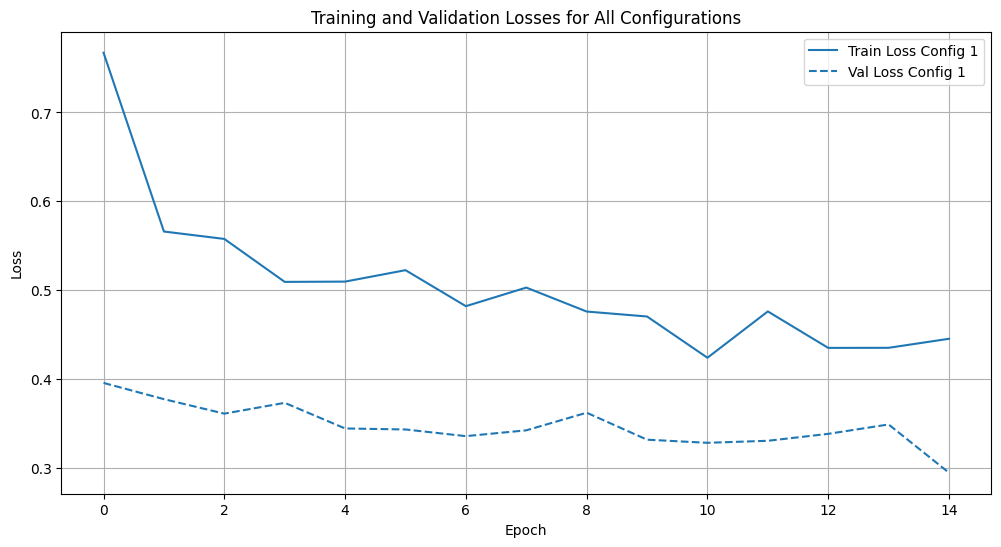

In [68]:
# plot_losses(all_losses, all_val_losses)
plot_losses([train_losses], [val_losses]) # only one configuration

In [69]:
# Evaluating the model
model.eval()
correct = 0
total = 0
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { correct / total}')

Accuracy on test set: 0.8862


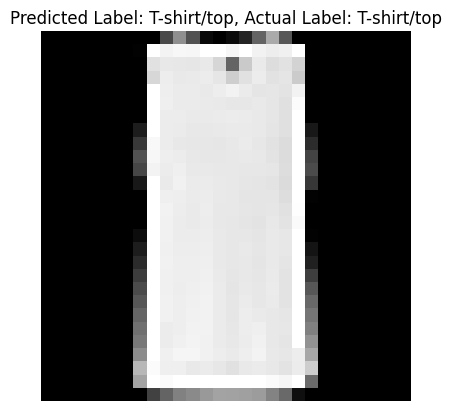

In [47]:
image_index = 27
test_image, test_label = test_dataset[image_index]

with torch.no_grad():
    model.eval()
    output = model(test_image.unsqueeze(0))
    _, predicted_label = torch.max(output, 1)

test_image_numpy = test_image.squeeze().numpy()

plt.imshow(test_image_numpy, cmap='gray')
plt.title(f'Predicted Label: {labels_map[predicted_label.item()]}, Actual Label: {labels_map[test_label]}')
plt.axis('off')
plt.show()

## PART - 3

### FMNIST CNN Implimentation with Keras

In [49]:
!pip install tensorflow

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/390.2 MB ? eta -:--:--
   ---------------------------------------- 2.6/390.2 MB 16.7 MB/s eta 0:00:24
    --------------------------------------- 5.8/390.2 MB 16.0 MB/s eta 0:00:25
    --------------------------------------- 9.7/390.2 MB 17.3 MB/s eta 0:00:23
   - -------------------------------------- 14.7/390.2

In [3]:
# Mapping the labels for the MNIST dataset
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

In [77]:
# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [78]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [26]:
kernel_size = (3, 3)
pool_size = (2, 2)
model = Sequential([
    Conv2D(16, kernel_size, activation='sigmoid', input_shape=(28, 28, 1)),  # 16 filters (reduced), 3x3 kernel
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling with 2x2 pool size
    # Flatten the output before passing to Dense layers
    Flatten(),
    Dense(64, activation='softmax'),  # Reduced from 128 to 64 units
    Dense(10, activation='softmax')  # Output layer with 10 units for classification
])

## change the architecture with CONV2D, Pooling, and Dense.

c:\Users\rgbmr\anaconda3\envs\project2\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [27]:
learning_rate = 0.01
epochs = 5
batch_size = 48

# Compile the model
model.compile(optimizer=SGD(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1035 - loss: 2.3027
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1314 - loss: 2.3016
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1207 - loss: 2.2983
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2072 - loss: 2.2555
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2067 - loss: 2.0952
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.2036 - loss: 1.9739
Test accuracy: 0.20241667330265045


In [29]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model with early stopping
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2062 - loss: 1.9479 - val_accuracy: 0.2096 - val_loss: 1.8898
Epoch 2/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2106 - loss: 1.8741 - val_accuracy: 0.2096 - val_loss: 1.8361
Epoch 3/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2130 - loss: 1.8251 - val_accuracy: 0.2111 - val_loss: 1.8008
Epoch 4/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2085 - loss: 1.7921 - val_accuracy: 0.2118 - val_loss: 1.7764
Epoch 5/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2129 - loss: 1.7705 - val_accuracy: 0.2147 - val_loss: 1.7590
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.2123 - loss: 1.7598
Test accuracy: 0.2094999998807907


In [71]:
fmnist_cnn_study = run_studies('fmnist_study_cnn', 'fmnist_study_cnn.db', 100)

Best hyperparameters: {'num_conv_layers': 3, 'num_filters_0': 64, 'num_filters_1': 128, 'num_filters_2': 128, 'fc_units_2': 64, 'activation': 'tanh', 'optimizer': 'Adam', 'lr': 0.0006224423091166731, 'dropout_rate': 0.12361946420484013}


In [81]:
fmnist_cnn_df = fmnist_cnn_study.trials_dataframe()
fmnist_cnn_df.head()

,number,value,datetime_start,datetime_complete,duration,params_activation,params_batch_size,params_dropout_rate,params_fc_units_0,params_fc_units_1,...,params_num_conv_layers,params_num_fc_layers,params_num_filters_0,params_num_filters_1,params_num_filters_2,params_optimizer,params_pool_size_0,params_pool_size_1,params_pool_size_2,state
0,0,0.912250,2024-10-26 12:43:15.050648,2024-10-26 12:44:52.174716,0 days 00:01:37.124068,relu,64.0,0.416872,256.0,NaN,...,1,1.0,32,NaN,NaN,RMSprop,3.0,NaN,NaN,COMPLETE
1,1,0.854000,2024-10-26 12:43:15.160018,2024-10-26 12:47:44.931115,0 days 00:04:29.771097,relu,32.0,0.053822,256.0,64.0,...,3,2.0,32,64.0,16.0,SGD,3.0,3.0,2.0,COMPLETE
2,2,0.903000,2024-10-26 12:43:15.160018,2024-10-26 13:00:09.553446,0 days 00:16:54.393428,relu,32.0,0.278942,128.0,128.0,...,2,2.0,128,128.0,NaN,SGD,2.0,2.0,NaN,COMPLETE
3,3,0.870667,2024-10-26 12:43:15.470557,2024-10-26 12:45:27.378221,0 days 00:02:11.907664,sigmoid,64.0,0.065871,128.0,64.0,...,3,2.0,16,16.0,16.0,Adam,2.0,3.0,2.0,COMPLETE
4,4,0.521583,2024-10-26 12:44:52.256231,2024-10-26 12:48:36.888362,0 days 00:03:44.632131,tanh,64.0,0.412135,128.0,64.0,...,2,2.0,64,64.0,NaN,Adam,3.0,3.0,NaN,COMPLETE


In [32]:
optuna.visualization.plot_optimization_history(fmnist_cnn_study)

In [46]:
optuna.visualization.plot_param_importances(fmnist_cnn_study)

In [47]:
optuna.visualization.plot_slice(fmnist_cnn_study)

In [82]:
fmnist_cnn_df.to_csv('fmnist_cnn_trial_data.csv', index=False)

In [88]:
fmnist_cnn_df[fmnist_cnn_df['params_num_conv_layers'] == 1].sort_values('value', ascending=False).head()

,number,value,datetime_start,datetime_complete,duration,params_activation,params_batch_size,params_dropout_rate,params_fc_units_0,params_fc_units_1,...,params_num_conv_layers,params_num_fc_layers,params_num_filters_0,params_num_filters_1,params_num_filters_2,params_optimizer,params_pool_size_0,params_pool_size_1,params_pool_size_2,state
15,15,0.913750,2024-10-26 13:02:23.381318,2024-10-26 13:02:54.865400,0 days 00:00:31.484082,relu,32.0,0.172114,256.0,NaN,...,1,1.0,32,NaN,NaN,RMSprop,3.0,NaN,NaN,COMPLETE
0,0,0.912250,2024-10-26 12:43:15.050648,2024-10-26 12:44:52.174716,0 days 00:01:37.124068,relu,64.0,0.416872,256.0,NaN,...,1,1.0,32,NaN,NaN,RMSprop,3.0,NaN,NaN,COMPLETE
23,23,0.904333,2024-10-26 13:06:58.205207,2024-10-26 13:09:24.955038,0 days 00:02:26.749831,relu,64.0,0.002428,256.0,NaN,...,1,1.0,32,NaN,NaN,Adam,3.0,NaN,NaN,COMPLETE
13,13,0.897833,2024-10-26 13:01:23.925123,2024-10-26 13:02:06.703534,0 days 00:00:42.778411,relu,32.0,0.485512,64.0,NaN,...,1,1.0,32,NaN,NaN,RMSprop,3.0,NaN,NaN,COMPLETE
22,22,0.896083,2024-10-26 13:06:58.080208,2024-10-26 13:09:24.439032,0 days 00:02:26.358824,relu,64.0,0.349268,256.0,NaN,...,1,1.0,32,NaN,NaN,Adam,3.0,NaN,NaN,COMPLETE


In [74]:
best_params = fmnist_cnn_study.best_params
best_params

{'num_conv_layers': 3,
 'num_filters_0': 64,
 'num_filters_1': 128,
 'num_filters_2': 128,
 'fc_units_2': 64,
 'activation': 'tanh',
 'optimizer': 'Adam',
 'lr': 0.0006224423091166731,
 'dropout_rate': 0.12361946420484013}

In [89]:
def build_model(best_params):
    # Build the model
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))
    model.add(Conv2D(best_params['num_filters_0'], kernel_size=(3, 3), # originally varied between 3 x 3 and 5 x 5
                     activation=best_params['activation'], padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2))) # originally varied between 2 x 2 and 3 x 3
    if best_params['num_conv_layers'] > 1:
        for i in range(1, best_params['num_conv_layers']):
            model.add(Conv2D(best_params[f'num_filters_{i}'], kernel_size=(3, 3),
                            activation=best_params['activation'], padding='same'))
            model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(best_params[f'fc_units_0'], activation=best_params['activation']))
    if best_params['dropout_rate'] > 0:
        model.add(Dropout(best_params['dropout_rate']))
    model.add(Dense(10, activation='softmax'))
    if best_params['optimizer'] == 'SGD':
        optimizer = SGD(learning_rate=best_params['lr'])
    elif best_params['optimizer'] == 'Adam':
        optimizer = Adam(learning_rate=best_params['lr'])
    else:
        optimizer = RMSprop(learning_rate=best_params['lr'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [79]:
model = build_model(best_params)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model with early stopping
model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7665 - loss: 0.9272 - val_accuracy: 0.8722 - val_loss: 0.5085
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8729 - loss: 0.4944 - val_accuracy: 0.8848 - val_loss: 0.4345
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8873 - loss: 0.4270 - val_accuracy: 0.8917 - val_loss: 0.4039
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8975 - loss: 0.3976 - val_accuracy: 0.8967 - val_loss: 0.3918
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9014 - loss: 0.3833 - val_accuracy: 0.8867 - val_loss: 0.4180
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9061 - loss: 0.3692 - val_accuracy: 0.8927 - val_loss: 0.3958
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9086 - loss: 0.3645 - val_accuracy: 0.8992 - val_loss: 0.3847
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9077 - loss: 

In [90]:
adjusted_params = best_params
adjusted_params['num_conv_layers'] = 1
adjusted_params['activation'] = 'relu'
adjusted_params['num_filters_0'] = 32
adjusted_params['optimizer'] = 'RMSProp'
adjusted_params['fc_units_0'] = 256
adjusted_params['dropout_rate'] = 0.172114
model = build_model(adjusted_params)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model with early stopping
model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7871 - loss: 0.6040 - val_accuracy: 0.8852 - val_loss: 0.3208
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8905 - loss: 0.3031 - val_accuracy: 0.8913 - val_loss: 0.2983
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9083 - loss: 0.2543 - val_accuracy: 0.9006 - val_loss: 0.2767
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9172 - loss: 0.2201 - val_accuracy: 0.9093 - val_loss: 0.2570
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9274 - loss: 0.1991 - val_accuracy: 0.9078 - val_loss: 0.2599
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9316 - loss: 0.1848 - val_accuracy: 0.9071 - val_loss: 0.2687
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9396 - loss: 0.1672 - val_accuracy: 0.9083 - val_loss: 0.2574
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9404 - loss: 0

In [39]:
adjusted_params['dropout_rate'] = 0.2
dropout_rates = [0.2, 0.3, 0.4, 0.5]
num_filters = [16, 32, 64, 128]
best_accuracy = 0
best_model = None
for dropout_rate in dropout_rates:
    adjusted_params['dropout_rate'] = dropout_rate
    for num_filter in num_filters:
        adjusted_params['num_filters_0'] = num_filter
        model = build_model(adjusted_params)
        model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping])
        loss, accuracy = model.evaluate(x_test, y_test)
        if best_accuracy < accuracy:
            best_accuracy = accuracy
            best_model = model
        print(f'Val accuracy with dropout rate {dropout_rate} and first layer # of filters {num_filter}: {accuracy}')

# Evaluate the model
loss, accuracy = best_model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7707 - loss: 0.6598 - val_accuracy: 0.8772 - val_loss: 0.3397
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8816 - loss: 0.3293 - val_accuracy: 0.8943 - val_loss: 0.2900
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8984 - loss: 0.2797 - val_accuracy: 0.9025 - val_loss: 0.2718
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9124 - loss: 0.2428 - val_accuracy: 0.9046 - val_loss: 0.2612
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9230 - loss: 0.2175 - val_accuracy: 0.9099 - val_loss: 0.2516
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8755 - loss: 0.3495
Val accuracy with dropout rate 0.2 and first layer # of filters 16: 0.8741000294685364
Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7645 - loss: 0.6589 - val_accuracy: 0.8522 - val_loss: 0.3901
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accurac

In [40]:
best_model.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_80 (Conv2D)              │ (None, 28, 28, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_81 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,112,672 (4.24 MB)

 Trainable params: 370,890 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 741,782 (2.83 MB)

In [45]:
adjusted_params['dropout_rate'] = 0.3
adjusted_params['num_filters_0'] = 128
model = build_model(adjusted_params)
reduce_lr = ReduceLROnPlateauKeras(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-6)
model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping, reduce_lr])
loss, acc = model.evaluate(x_test, y_test)
print('Test accuracy:', acc)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.7608 - loss: 0.6752 - val_accuracy: 0.8832 - val_loss: 0.3306 - learning_rate: 6.2244e-04
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.8808 - loss: 0.3377 - val_accuracy: 0.8983 - val_loss: 0.2844 - learning_rate: 6.2244e-04
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.9020 - loss: 0.2753 - val_accuracy: 0.9049 - val_loss: 0.2732 - learning_rate: 6.2244e-04
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.9186 - loss: 0.2334 - val_accuracy: 0.9038 - val_loss: 0.2678 - learning_rate: 6.2244e-04
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.9242 - loss: 0.2122 - val_accuracy: 0.9140 - val_loss: 0.2469 - learning_rate: 6.2244e-04
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9376 - loss: 0.1798 - val_accuracy: 0.9136 - val_loss: 0.2422 - learning_rate: 6.2244e-04
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


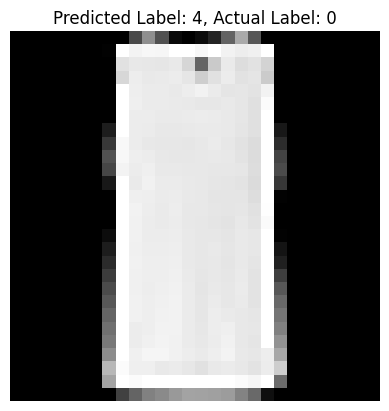

In [18]:
image_index = 27

# Extract the test image and label
test_image = x_test[image_index]
test_label = np.argmax(y_test[image_index])

# Reshape the test image for prediction (Keras expects a batch dimension)
test_image_reshaped = np.expand_dims(test_image, axis=0)

# Make predictions on the test image
predicted_label = np.argmax(model.predict(test_image_reshaped), axis=-1)

# Plot the test image with predicted and actual labels
plt.imshow(test_image, cmap='gray')
plt.title(f'Predicted Label: {predicted_label[0]}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

### Just to explore TensorFlow Implemenation of CNN.

Not Required For Submission.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(16, (5, 5), activation='sigmoid', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='tanh'),
    layers.MaxPooling2D((3, 3)),
    layers.Flatten(),
    layers.Dense(128, activation='softmax'),
    layers.Dense(10)
])

# Compile the model
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(train_images.reshape(-1, 28, 28, 1), train_labels, epochs=5)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images.reshape(-1, 28, 28, 1), test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1010 - loss: 2.3026
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0984 - loss: 2.3026
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1009 - loss: 2.3026
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1026 - loss: 2.3025
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1026 - loss: 2.3024
313/313 - 2s - 7ms/step - accuracy: 0.1000 - loss: 2.3023

Test accuracy: 0.10000000149011612


## AUTOMATED TUNING (EXETENDED)

In [ ]:
https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams